In [4]:
import matplotlib.pyplot as plt
import torch

from data import Burgers_Dataset
from unet import Unet2D
from diffuser import GaussianDiffusion

In [2]:
ds = Burgers_Dataset("../data/burgers_data_v1e-02_N200.mat")

Loaded 200 samples from ../data/burgers_data_v1e-02_N200.mat
Shape of x: torch.Size([200, 1, 100, 128])


In [3]:
model = Unet2D(
    channels=1,
    cond_channels=1,
    channel_mults=(1, 2, 4, 8),
    init_conv_channels=32,
    init_conv_kernel_size=5
)
diffusion_model = GaussianDiffusion(
    model=model,
    sample_size=(1, 100, 128),
    timesteps=1000,
    objective='pred_x0',
    physics_loss_weight=1.0
)
diffusion_model = diffusion_model.to("cuda:0")

In [5]:
diffusion_model.model.load_state_dict(torch.load('./ckpts/burgers_1.0phyloss/ckpt.pt')['model_state_dict'])

<All keys matched successfully>

In [6]:
x = ds[:4]['x']
y = ds[:4]['y']

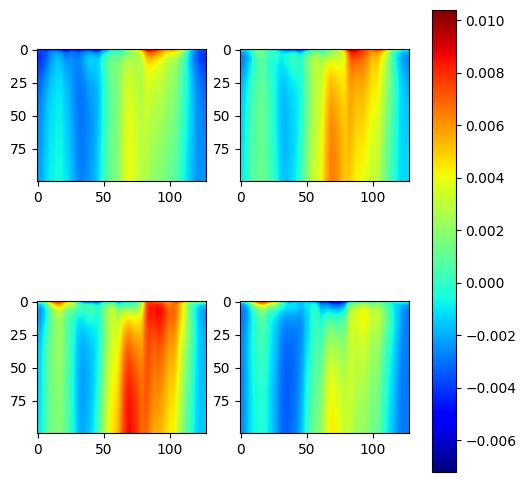

In [17]:
fig, ax = plt.subplots(2, 2, figsize=(6, 6))
for i in range(4):
    im = ax[i // 2, i % 2].imshow(x[i, 0], cmap='jet')
fig.colorbar(im, ax=ax)

In [9]:
x_pred = diffusion_model.sample(cond=y.to("cuda:0"))

DDPM sampling: 100%|██████████| 1000/1000 [00:50<00:00, 19.83it/s]


In [10]:
x_pred = x_pred.cpu().detach()

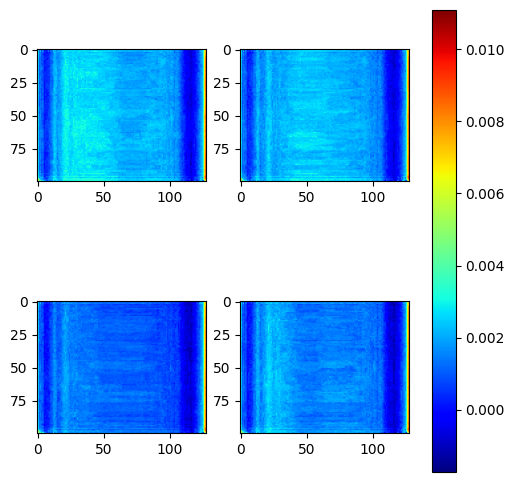

In [18]:
fig, ax = plt.subplots(2, 2, figsize=(6, 6))
for i in range(4):
    im = ax[i // 2, i % 2].imshow(x_pred[i, 0], cmap='jet')
fig.colorbar(im, ax=ax)

In [12]:
from physics_loss import burgers_residual

In [13]:
loss = burgers_residual(x, visc=1e-2, dt=1e-2)
loss_pred = burgers_residual(x_pred, visc=1e-2, dt=1e-2)

In [14]:
loss

tensor(0.0003)

In [15]:
loss_pred

tensor(0.0003)

In [16]:
torch.mean((x_pred - x)**2)

tensor(1.1374e-05)